**Group-08**<br/>
<font style="color:red"> **Belhassen Ghoul <br/> Robin Ehrensperger <br/> Dominic Diedenhofen**</font>

In [19]:
from datetime import datetime
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchsummary import summary
import matplotlib.pyplot as plt

### Loading the Data

Click through the cells below to load the MNIST dataset and learn how to access its samples.

#### Dataset

In [20]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [21]:
print(training_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [22]:
print(len(training_data))
x, y = training_data[5] 
print(type(x), x.shape, x.dtype)
print(type(y), y)

60000
<class 'torch.Tensor'> torch.Size([1, 28, 28]) torch.float32
<class 'int'> 2


#### Depict samples

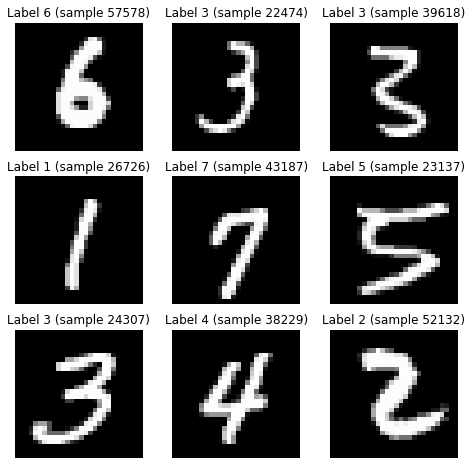

In [23]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title("Label %i (sample %i)"%(label,sample_idx))
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

#### Data Loader (see lecture)

In [24]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)

In [25]:
data_train, labels_train = next(iter(train_dataloader))
print(f"Feature batch shape: {data_train.shape}")
print(f"Labels batch shape: {labels_train.shape}")

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


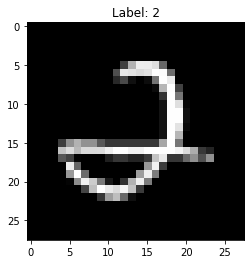

In [26]:
img = data_train[0].squeeze()
label = labels_train[0]
plt.imshow(img, cmap="gray")
plt.title(f"Label: {label}")
plt.show()

### Multinomial Logistic Regression

Now, implement the model, i.e. multinomial logistic regression and the loss/cost function (cross-entropy cost).

To that end, implement the python functions below. 
All arguments are pytorch tensors with indicated shapes.

In [27]:
def linear_trsf(x,W,b):
    """
    x -- tensor with shape (nb,1,28,28)
    W -- tensor with shape (10,28*28)
    b -- tensor with shape (1,10)
    """
    # YOUR CODE (START)
    nb = x.shape[0]
    x1 = x.view(nb,-1)
    return torch.matmul(x1,W.T)+b
    # YOUR CODE (END)

def softmax(z):
    """
    z -- tensor of shape (nb,10)
    """
    # YOUR CODE (START)
    s = torch.exp(z)
    return s/torch.sum(s,dim =1, keepdims=True)
    # YOUR CODE (END)
    
def predict(x,W,b):
    """
    x -- tensor with shape (nb,1,28,28)
    W -- tensor with shape (10,28*28)
    b -- tensor with shape (1,10)
    """
    # YOUR CODE (START)
    return softmax(linear_trsf(x,W,b))
    # YOUR CODE (END)


##### TEST

In [29]:
W,b = torch.randn((10,28*28)), torch.zeros((1,10))
print(W.shape,b.shape)
u = predict(x,W,b)
print(u.shape, torch.sum(u).item())

torch.Size([10, 784]) torch.Size([1, 10])
torch.Size([1, 10]) 1.0


#### Loss Function

In [30]:
def loss_ce(y, uhat):
    """
    y -- tensor with shape (nb,1) and possible values (0,1,2,3,4,5,6,7,8,9)
    uhat -- tensor with shape (nb,10)
    returns -- per sample loss 
    """
    # YOUR CODE (START)
    nb = y.shape[0]
    return -torch.log(uhat[torch.arange(nb),y[:]])
    # YOUR CODE (END)

def cost_ce(y,uhat):
    """
    y -- tensor with shape (nb,1) and possible values (0,1,2,3,4,5,6,7,8,9)
    uhat -- tensor with shape (nb,10)
    return -- per batch mean of losses
    """
    # YOUR CODE (START)    
    return torch.mean(loss_ce(y,uhat))
    # YOUR CODE (END)


##### TEST

In [31]:
import numpy as np
y = torch.tensor([0,2])
z = torch.tensor([[1.,2,3],[2,2,2]]).reshape(-1,3)
uhat = softmax(z)
print(loss_ce(y,uhat), cost_ce(y,uhat))

tensor([2.4076, 1.0986]) tensor(1.7531)


### Gradient Descent for the given Model

For the training, we adopt gradient descent - and start with the implementation of the gradient of the cost function (cross-entropy cost function).  

#### Gradient

In [32]:
def grad_loss_ce(x,u,uhat):
    """
    x -- tensor with shape (nb,1, 28*28)
    u -- tensor with shape (nb,10)
    uhat -- tensor with shape (nb,10)
    returns -- gradW, gradb (same dimension as W and b)
    """
    # YOUR CODE (START)
    gradw = torch.mean((uhat-u).view(-1,10,1)*x.view(-1,1,28*28),dim=0)
    gradb = torch.mean((uhat-u),dim=0)
    return gradw,gradb
    # YOUR CODE (END)

#### Metrics - Cost, Accuracy

For tracking the progress of the training, we will use two functions: the cost and the accuracy. 

In [33]:
def metrics(X,Y,W,b):
    """
    X -- tensor with shape (nb,1,28*28)
    Y -- tensor with shape (nb,10)
    W -- tensor with shape (10,28*28)
    b -- tensor with shape (10,1)
    
    return -- cost, acc (both scalars)
    """
    # YOUR CODE (START) 
    cost = cost_ce(Y,predict(X,W,b))
    acc = torch.sum(predict(X,W,b).argmax(1)==Y)/Y.shape[0]
    return cost, acc
    # YOUR CODE (END)


### Mini-Batch Gradient Descent

In [44]:
nepochs = 10
alpha = 0.5
nclasses = 10
nbatch = 64
num_batches = len(training_data)/float(nbatch)

cost_hist = []
acc_hist = []
cost_hist_test = []
acc_hist_test = []

# data loader
train_dataloader = DataLoader(training_data, batch_size=nbatch, shuffle=True)

# test data - we can load all samples for the test since it easily fits into memory
Xtest,Ytest = next(iter(DataLoader(test_data, batch_size=10000, shuffle=True))) 

# initial parameters
W,b = torch.randn((10,28*28)), torch.zeros((1,10))

d0 = datetime.now()

for epoch in range(nepochs):
    cost = 0.0
    acc = 0.0
    cost_test = 0.0
    acc_test = 0.0
    for X,Y in train_dataloader:
        uhat = predict(X,W,b)
        u = (Y.view(-1,1)==torch.arange(nclasses).view(1,nclasses)).float()
        dW, db = grad_loss_ce(X,u,uhat)
        W = W-alpha*dW
        b = b-alpha*db

        cost, acc = metrics(X,Y,W,b)
        cost_test, acc_test = metrics(Xtest,Ytest,W,b)

    cost_hist.append(cost)
    acc_hist.append(acc)

    cost_hist_test.append(cost_test)
    acc_hist_test.append(acc_test)

    print("Epoch %i: %f, %f, %f, %f"%(epoch, cost, acc, cost_test, acc_test))
    
d = datetime.now()
print((d-d0).total_seconds()/nepochs)  

Epoch 0: 0.925116, 0.750000, 0.577419, 0.871100
Epoch 1: 0.319535, 0.937500, 0.497089, 0.885100
Epoch 2: 0.162855, 0.906250, 0.411426, 0.899700
Epoch 3: 0.459629, 0.906250, 0.399250, 0.897500
Epoch 4: 0.205762, 0.937500, 0.389935, 0.901800
Epoch 5: 0.299483, 0.937500, 0.363113, 0.906300
Epoch 6: 0.166884, 0.968750, 0.372406, 0.898200
Epoch 7: 0.255995, 0.937500, 0.352854, 0.910900
Epoch 8: 0.091046, 0.968750, 0.347495, 0.909000
Epoch 9: 0.048653, 1.000000, 0.337451, 0.911200
9.7706064


Text(0.5, 1.0, 'Accuracy')

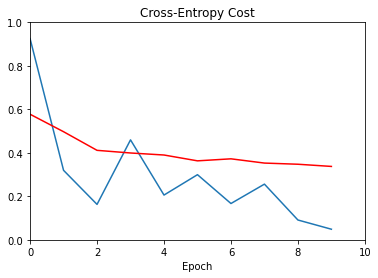

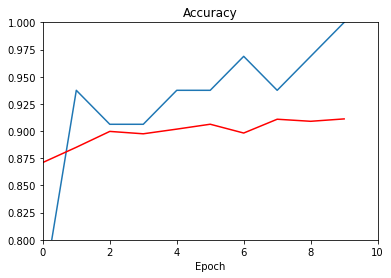

In [45]:
plt.figure(1)
plt.plot(torch.arange(nepochs), cost_hist, "-")
plt.plot(torch.arange(nepochs), cost_hist_test, "r-")
plt.xlabel("Epoch")
plt.xlim(0,nepochs)
plt.ylim(0,1)
plt.title("Cross-Entropy Cost")
plt.figure(2)
plt.plot(torch.arange(nepochs), acc_hist,"-")
plt.plot(torch.arange(nepochs), acc_hist_test,"r-")
plt.xlabel("Epoch")
plt.xlim(0,nepochs)
plt.ylim(0.8,1)
plt.title("Accuracy")

### With Full-Fledge PyTorch

In [46]:
class NeuralNetwork(torch.nn.Module):
    
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = torch.nn.Flatten()
        self.linear  = torch.nn.Linear(28*28,10)
    
    def forward(self, x): # use just one linear layer and pytorch's CrossEntropyLoss
        z = self.linear(self.flatten(x))
        return z


In [47]:
model = NeuralNetwork()
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=784, out_features=10, bias=True)
)


In [48]:
summary(model, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                   [-1, 10]           7,850
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.03
Estimated Total Size (MB): 0.04
----------------------------------------------------------------


In [49]:
nbatch = 64
nepochs = 10
learning_rate = 0.1

cost_hist = []
cost_hist_test = []
acc_hist = []
acc_hist_test = []

cost_ce = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

training_loader = DataLoader(training_data, batch_size=nbatch, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10000, shuffle=True)

Xtest, Ytest = next(iter(test_loader))
size = len(training_loader.dataset)
nbatches = len(training_loader)

cost, acc = 0.0, 0.0
for epoch in range(nepochs):
    for batch, (X, Y) in enumerate(training_loader):

        pred = model(X)    
        loss= cost_ce(pred,Y)    

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()    
        
        acc += (pred.argmax(dim=1)==Y).type(torch.float).sum().item()
        cost += cost_ce(pred,Y)

    cost /= nbatches
    acc /= size
    
    cost_test, acc_test = 0.0, 0.0
    with torch.no_grad():
        for X,Y in test_loader:
            pred = model(X)
            acc_test += (pred.argmax(dim=1)==Y).type(torch.float).sum().item()/len(test_loader.dataset)
            cost_test += cost_ce(pred,Y)
            
    print("Epoch %i: %f, %f, %f, %f"%(epoch, cost, acc, cost_test, acc_test))
    cost_hist.append(cost)
    cost_hist_test.append(cost_test)
    acc_hist.append(acc)
    acc_hist_test.append(acc_test)


Epoch 0: 0.477643, 0.876333, 0.333980, 0.909000
Epoch 1: 0.337343, 0.905665, 0.309374, 0.913300
Epoch 2: 0.314584, 0.910882, 0.294308, 0.918200
Epoch 3: 0.302583, 0.915649, 0.287124, 0.919900
Epoch 4: 0.294752, 0.916949, 0.284869, 0.919300
Epoch 5: 0.289361, 0.919515, 0.281362, 0.920100
Epoch 6: 0.284968, 0.920715, 0.278920, 0.919800
Epoch 7: 0.281339, 0.921932, 0.278281, 0.922600
Epoch 8: 0.278544, 0.922265, 0.274974, 0.923300
Epoch 9: 0.275940, 0.923665, 0.274359, 0.922200


Text(0.5, 1.0, 'Accuracy')

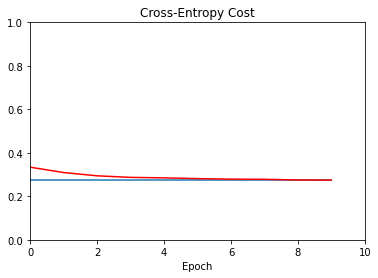

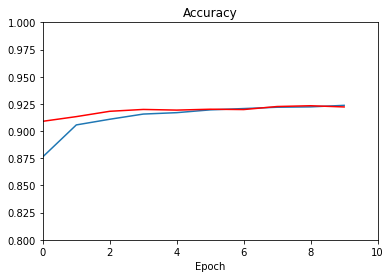

In [50]:
plt.figure(1)
plt.plot(torch.arange(nepochs), torch.tensor(cost_hist), "-")
plt.plot(torch.arange(nepochs), cost_hist_test, "r-")
plt.xlabel("Epoch")
plt.xlim(0,nepochs)
plt.ylim(0,1)
plt.title("Cross-Entropy Cost")
plt.figure(2)
plt.plot(torch.arange(nepochs), acc_hist,"-")
plt.plot(torch.arange(nepochs), acc_hist_test,"r-")
plt.xlabel("Epoch")
plt.xlim(0,nepochs)
plt.ylim(0.8,1)
plt.title("Accuracy")

### Analysis of different settings for learning rate and batch size

Now analyse the training progress with five, well selected settings for each, the learning rate and the batch size.
Make sure that for each setting, a more or less "stable" test performance is achieved, i.e. a status where the test accurace is no longer expected to improve. Choose the number of epochs accordingly.

Finally, prepare suitable plots and tables to make the comparison transparent and characterize in words what you observe. 

Can you explain the behavior?</br> <font style = "color:red"> With higher batch size it needs a higher epoch to get a stable performance. But with those plots and "table" I did not see any behavior... may can you tell me what kind of behaviour it should have? </font>

In [125]:
nbatch = [4,8,16,64,512]
nepochs = 10
learning_rate = [0.000001,0.1,1,10,1000]

acc_histLR = []
for lr in range(len(learning_rate)):
    print("Learning Rate %f: "%(learning_rate[lr]))
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate[lr])

    acc_histBT = []
    for bt in range(len(nbatch)):
        print("Batch size %f: "%(nbatch[bt]))
        training_loader = DataLoader(training_data, batch_size=nbatch[lr], shuffle=True)

        size = len(training_loader.dataset)
        nbatches = len(training_loader)

        cost, acc = 0.0, 0.0
        acc_hist = []
        for epoch in range(nepochs):
            for batch, (X, Y) in enumerate(training_loader):

                pred = model(X)    
                loss= cost_ce(pred,Y)    

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()    
        
                acc += (pred.argmax(dim=1)==Y).type(torch.float).sum().item()
            

            acc /= size
            
            #print("Epoch %i: %f"%(epoch,acc))
            acc_hist.append(acc)
    
        acc_histBT.append(acc_hist)
    acc_histLR.append(acc_histBT)

Learning Rate 0.000001: 
Batch size 4.000000: 
Batch size 8.000000: 
Batch size 16.000000: 
Batch size 64.000000: 
Batch size 512.000000: 
Learning Rate 0.100000: 
Batch size 4.000000: 
Batch size 8.000000: 
Batch size 16.000000: 
Batch size 64.000000: 
Batch size 512.000000: 
Learning Rate 1.000000: 
Batch size 4.000000: 
Batch size 8.000000: 
Batch size 16.000000: 
Batch size 64.000000: 
Batch size 512.000000: 
Learning Rate 10.000000: 
Batch size 4.000000: 
Batch size 8.000000: 
Batch size 16.000000: 
Batch size 64.000000: 
Batch size 512.000000: 
Learning Rate 1000.000000: 
Batch size 4.000000: 
Batch size 8.000000: 
Batch size 16.000000: 
Batch size 64.000000: 
Batch size 512.000000: 


In [126]:
maxAcc = torch.tensor(acc_histLR)
maxLR = []
for i in range(len(acc_histLR)):
    maxBT = []
    for j in range(len(acc_histBT)):
        maxBT.append(torch.max(maxAcc[i,j]))
    maxLR.append(maxBT)
    print(print("Learning Rate %f: "%(learning_rate[i])),(maxLR[i]))

Learning Rate 0.000001: 
None [tensor(0.8719), tensor(0.8719), tensor(0.8719), tensor(0.8719), tensor(0.8719)]
Learning Rate 0.100000: 
None [tensor(0.9346), tensor(0.9359), tensor(0.9361), tensor(0.9363), tensor(0.9367)]
Learning Rate 1.000000: 
None [tensor(0.9366), tensor(0.9362), tensor(0.9350), tensor(0.9344), tensor(0.9331)]
Learning Rate 10.000000: 
None [tensor(0.9323), tensor(0.9312), tensor(0.9308), tensor(0.9295), tensor(0.9292)]
Learning Rate 1000.000000: 
None [tensor(0.9069), tensor(0.9125), tensor(0.9149), tensor(0.9059), tensor(0.9090)]


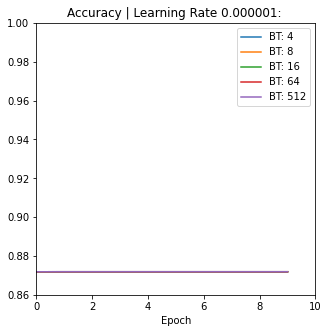

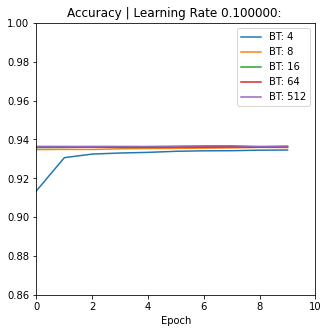

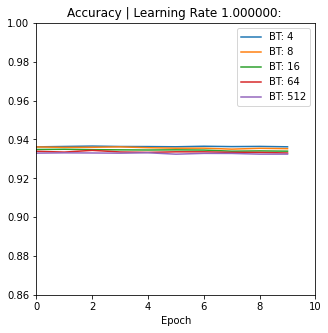

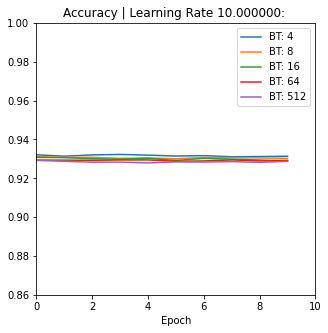

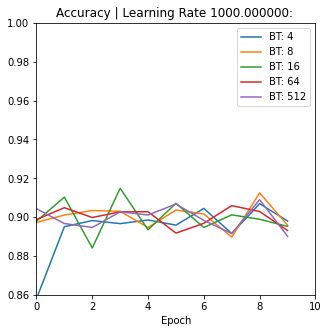

In [130]:
ALR =torch.tensor(acc_histLR)
maxBT = []
for i in range(len(acc_histBT)):
    accBT = max(acc_histBT[i])
    maxBT = accBT

for i in range(len(learning_rate)):
    plt.figure(figsize=(5,5))
    for j in range(len(nbatch)):
        plt.plot(torch.arange(nepochs), ALR[i][j],"-")
        plt.legend(['BT: 4', 'BT: 8','BT: 16','BT: 64',"BT: 512"], loc=1)
    plt.xlabel("Epoch")
    plt.xlim(0,nepochs)
    plt.ylim(0.86,1)
    plt.title("Accuracy | Learning Rate %f: "%(learning_rate[i]))
    plt.show()